In [1]:
from platform import python_version
import tensorflow as tf

print(tf.test.is_gpu_available())
print(python_version())

False
3.7.5


In [2]:
import os
import numpy as np
from os import listdir
from PIL import Image
import time
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers
from keras import backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
path="datasets/TSKinFace_Data/TSKinFace_cropped/"
randomiser = np.random.RandomState(123)

In [4]:
img_size = 64
mean = 0.
std_dev = 0.02
lr = 0.00001
b1 = 0.9
b2 = 0.99
sd_random_normal_init = 0.02

EPOCHS = 300
batch = 64

In [5]:
def generate_image(family_dir, family_number, gender):
    dic={}
    sub = ["F" , "M", gender]
    family_pth = path+"/"+family_dir+"/" + family_dir + "-" + str(family_number) + "-"
    for ele in sub:
        addr = family_pth+ele+".jpg"
        original_img = np.array(Image.open(addr))
        if ele =='F':
            dic['father'] = original_img
        elif ele == 'M':
            dic['mother'] = original_img
        elif ele == 'S':
            dic['child'] = original_img    
            dic['gender']=np.zeros((original_img.shape))
        elif ele == 'D':
            dic['child'] = original_img    
            dic['gender'] = np.ones((original_img.shape))
    return [dic['father'],dic['mother'],dic['gender'],dic['child']]

def generate_batch(families_batch):
    np_images=[]
    for family in families_batch:
        res = generate_image(family[0], family[1], family[2])
        if( res != None):
            np_images.append(res)
    return np_images

In [6]:
all_families = []
for i in range(285):
    all_families.append(['FMS', i+1, 'S'])
for i in range(274):
    all_families.append(['FMD', i+1, 'D'])
for i in range(228):
    all_families.append(['FMSD', i+1, 'D'])  
    all_families.append(['FMSD', i+1, 'S'])  
randomiser.shuffle(all_families)
train_families = all_families[:-10]
test_families = all_families[-10:]

In [7]:
OUTPUT_CHANNELS = 3

In [8]:
def gen_downsample_parent(filters, size, apply_batchnorm=True, apply_dropout=False):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.ELU())
        
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(rate = 0.5))

    return result

In [9]:
def gen_upsample(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.ELU())

    return result

In [10]:
def EncoderNN():
    down_stack_parent = [
    gen_downsample_parent(32,4,apply_batchnorm=True, apply_dropout=False),
    gen_downsample_parent(64,4,apply_batchnorm=True, apply_dropout=False)
    ]
    
    down_stack_noise =[
    gen_upsample(64,4,apply_batchnorm=True), #8x8x64
    gen_upsample(32,4,apply_batchnorm=True) #16x16x32      
    ]
    
    final_conv =[
        gen_upsample(32,4 ,apply_batchnorm = True)
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')

    concat = tf.keras.layers.Concatenate()

    father = tf.keras.layers.Input(shape=(img_size,img_size,3))
    mother = tf.keras.layers.Input(shape=(img_size,img_size,3))
    noise = tf.keras.layers.Input(shape=(4,4,64))
    
    
    
    
    x1 = father
    for down in down_stack_parent:
        x1 = down(x1)
    
#     print(x1.shape)
    
    x2 = mother
    for down in down_stack_parent:
        x2 = down(x2) 
    
    x3 = noise
    for down in down_stack_noise:
        x3 = down(x3)
#     print(x3.shape)
    
#     print(x2.shape)
    
    final = concat([x1,x2,x3])
    final = final_conv[0](final)
    final = last(final)
    
#     print(final.shape)
    return tf.keras.Model(inputs=[father, mother, noise], outputs=final)

In [11]:
supervised = EncoderNN()

In [12]:
encoder_optimizer = tf.keras.optimizers.Adam(learning_rate = lr, beta_1=b1)

In [13]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [14]:
def train_encoder(father_batch, mother_batch, noise, target_batch, b_size):
    with tf.GradientTape() as enc_tape:
        gen_outputs = supervised([father_batch, mother_batch, noise], training=True)
        
        diff = tf.abs(target_batch - gen_outputs)
        flatten_diff = tf.reshape(diff, (b_size, img_size*img_size*3))
        
        encoder_loss_batch = tf.reduce_mean(flatten_diff, axis=1)**0.5
        encoder_loss = tf.reduce_mean(encoder_loss_batch)
    
    print("ENCODER_LOSS: ",tensor_to_array(encoder_loss))
    #calculate gradients
    encoder_gradients = enc_tape.gradient(encoder_loss,supervised.trainable_variables)

    #apply gradients on optimizer
    encoder_optimizer.apply_gradients(zip(encoder_gradients,supervised.trainable_variables))
    


In [15]:
def fit_encoder(train_ds, epochs, test_ds, batch):
    losses=np.array([])
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch+1))
        start = time.time()
        for i in range(len(train_ds)//batch):
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))
            batch_data = batch_data / 255 * 2 -1
            
            
            print("Generated batch", batch_data.shape)
            
            X_Father_train = tf.convert_to_tensor(batch_data[:,0],dtype =tf.float32)
            X_Mother_train = tf.convert_to_tensor(batch_data[:,1],dtype =tf.float32)
            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            
            noise = tf.random.normal((batch,4,4,64),mean= 0.0, stddev=1.0)

            
            train_encoder(X_Father_train, X_Mother_train, noise, Y_train,batch)
            
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
    print("______________________________TRAINING COMPLETED_______________________________")

In [84]:
train_dataset = all_families[:-100]
test_dataset = all_families[-100:]
supervised = EncoderNN()

with tf.device('/gpu:0'):
    fit_encoder(train_dataset, EPOCHS, test_dataset,batch)

______________________________EPOCH 1_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.68378854
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6863417
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6832324
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6759322
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6779566
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.68593305
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6852745
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.66794604
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6835263
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.66722506
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.667351
Trained for batch 11/14
Generated bat

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6129902
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6316284
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.63012797
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6178709
Trained for batch 14/14
______________________________EPOCH 8_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6206291
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6247017
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.63150656
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.61847067
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.61821616
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.63727283
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.62463105
Trained for batch 7/14
Generate

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6010034
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5925817
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.60736513
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5936233
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5848764
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6061976
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6026213
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5928612
Trained for batch 14/14
______________________________EPOCH 15_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.59472454
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5994749
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.61147624
Trained for batch 3/14
Generated

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.6035013
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5854854
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5833869
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.61016
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5881892
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5815087
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5956841
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.58287066
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.573151
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.59454787
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5911798
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.58169025
Trained for batch 14/14

Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5750468
Trained for batch 14/14
______________________________EPOCH 28_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5764665
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.58257324
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5969309
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57836777
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57574624
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.60377616
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.58068675
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57453805
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5890596
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5758065
Trained f

ENCODER_LOSS:  0.56978154
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.58438104
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57089674
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5618326
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5821488
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5792801
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56956273
Trained for batch 14/14
______________________________EPOCH 35_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57035255
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57711864
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.59230065
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5722022
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCOD

Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.588722
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56819534
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56561697
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5945843
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57080233
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56620455
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.58062315
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56634116
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5578042
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5770873
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5743329
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.564

ENCODER_LOSS:  0.5731982
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57116604
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56081843
Trained for batch 14/14
______________________________EPOCH 48_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56149656
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56894684
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5855917
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5645163
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56080484
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5912325
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5667385
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5621797
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_L

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55977374
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5747018
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55962324
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55117023
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5700803
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5675472
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5572145
Trained for batch 14/14
______________________________EPOCH 55_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5571977
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56571525
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5828215
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56084013
Trained for batch 4/14
Generat

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5808074
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5587616
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55393994
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.58504564
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56073165
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55717236
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5725044
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55641675
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5487582
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56656575
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5654205
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5535094
Trained for batch

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56435376
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56308526
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55111694
Trained for batch 14/14
______________________________EPOCH 68_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5517515
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5608212
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.579185
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5555801
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5508019
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5830641
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5586843
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5555945
Trained for batch 8/14
Generated ba

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55692786
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55363894
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5682794
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5519948
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54449576
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56166005
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5612973
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5489563
Trained for batch 14/14
______________________________EPOCH 75_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54936665
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55874014
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57756364
Trained for batch 3/14
Gener

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5571808
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5762251
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55266535
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5466554
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5792239
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55555475
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55285144
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56652904
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54979837
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.543486
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5595516
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.559306
Trained for batch 13/

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55874205
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5577942
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5450202
Trained for batch 14/14
______________________________EPOCH 88_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5456703
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5556191
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.574835
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5513586
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54432756
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5779288
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55394673
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55099285
Trained for batch 8/14
Generated b

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5528221
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5499909
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56461453
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54732704
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5406954
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55699
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55626816
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54298013
Trained for batch 14/14
______________________________EPOCH 95_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54422164
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55429244
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57330704
Trained for batch 3/14
Generat

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5529078
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57231283
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5496027
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5419258
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5752022
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55150056
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5487056
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5625611
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5463371
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53953993
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55549693
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55519134
Trained for batch 1

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5382953
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55471003
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55341995
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5399935
Trained for batch 14/14
______________________________EPOCH 108_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5421767
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5522208
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57183623
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54807013
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.540131
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5736648
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5501497
Trained for batch 7/14
Generated

ENCODER_LOSS:  0.5385109
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5731453
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5493329
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.547364
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5615931
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5441991
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5381808
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5537682
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5530778
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5384407
Trained for batch 14/14
______________________________EPOCH 115_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54022795
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOS

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53966534
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5499631
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5696609
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54639
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53735256
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57221776
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5483248
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5468574
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.559849
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5431613
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5373888
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5528924
Trained for batch 12/14
G

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53585374
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55177754
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5513459
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5358494
Trained for batch 14/14
______________________________EPOCH 128_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53967667
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5492517
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5688468
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54526997
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.536492
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57085276
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5480378
Trained for batch 7/14
Generate

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5360451
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.57015467
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5473215
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5447165
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55833143
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5413257
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53544414
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55133164
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54992914
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53554845
Trained for batch 14/14
______________________________EPOCH 135_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5383457
Trained for batch 1/14
Gener

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5372422
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5473311
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5672027
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5440053
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5344589
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56992054
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5463195
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54516816
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55675733
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5410911
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5354682
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5502089
Trained for batch 12/1

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5352775
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54969716
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54861474
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53336674
Trained for batch 14/14
______________________________EPOCH 148_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53716964
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.547696
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5669723
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54417473
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53413504
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5690485
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54599166
Trained for batch 7/14
Genera

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.533806
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5681125
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5461442
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.544321
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5563054
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54051787
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5346149
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54875207
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.547547
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5332591
Trained for batch 14/14
______________________________EPOCH 155_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5362486
Trained for batch 1/14
Generated ba

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53181124
Trained for batch 14/14
______________________________EPOCH 161_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53588134
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5458845
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.566028
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.542923
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.533175
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5681995
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5454523
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5435525
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55593383
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.539688
Trained for batch 10/14
Generated batch

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5554768
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53925043
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53350455
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54900265
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5469971
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5320921
Trained for batch 14/14
______________________________EPOCH 168_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53561133
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54525393
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56582904
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54238355
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5324476
Trained for batch 5/14
Gene

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54115087
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53197676
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5668635
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54426885
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5427429
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5558388
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5388434
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5333389
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5479022
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54680496
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5307958
Trained for batch 14/14
______________________________EPOCH 175_______________________________
Generat

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54601705
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53137535
Trained for batch 14/14
______________________________EPOCH 181_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53448915
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54526573
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5648134
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54169035
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53150123
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56706655
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5440463
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5422985
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55437684
Trained for batch 9/14
Genera

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5430711
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5544847
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53789103
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53308654
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54700994
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54575086
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5301117
Trained for batch 14/14
______________________________EPOCH 188_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53427756
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54479635
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56493187
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54147524
Trained for batch 4/14
Gen

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5646752
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54066956
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53049076
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5654129
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54389954
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54239184
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5540426
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53768444
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53231424
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5473047
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54526806
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.529459
Trained for batch

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5451926
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5293119
Trained for batch 14/14
______________________________EPOCH 201_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53342587
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5447296
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5634124
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54016775
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.529986
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56560826
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.543982
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54151666
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.553831
Trained for batch 9/14
Generated bat

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54289585
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54208994
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5541184
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5367351
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53220636
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5466815
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5441989
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.52914196
Trained for batch 14/14
______________________________EPOCH 208_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5330024
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5430028
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5633632
Trained for batch 3/14
Generat

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5333775
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54308295
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.563015
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53955233
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.52991563
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56484026
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5432198
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54193217
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55310786
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53659105
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5314888
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5463551
Trained for batch 1

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5289217
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56535196
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54255176
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54153967
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55240166
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5361495
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5317542
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5462281
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5435366
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.52866244
Trained for batch 14/14
______________________________EPOCH 228_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53198814
Trained for batch 1/14
Gener

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5321989
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5431675
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5632578
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.538604
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.52911234
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5642613
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5420182
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5416211
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55310535
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53644407
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5317826
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5456916
Trained for batch 12/14

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5358748
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53161037
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5452398
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54322124
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5276519
Trained for batch 14/14
______________________________EPOCH 241_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53164244
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54294634
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5627289
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5382761
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.52829826
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56465954
Trained for batch 6/14
Gener

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.52879703
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.564165
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54239845
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5415159
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5522286
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53534734
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53036904
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54470736
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5427453
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5278065
Trained for batch 14/14
______________________________EPOCH 248_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5318637
Trained for batch 1/14
Generat

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5269152
Trained for batch 14/14
______________________________EPOCH 254_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5318591
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54163575
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56271493
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53824735
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5282282
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56393015
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5419486
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54143316
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5523542
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5354593
Trained for batch 10/14
Generated

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54148054
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5516218
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53573275
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5311726
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54427373
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54224885
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.52705944
Trained for batch 14/14
______________________________EPOCH 261_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5314007
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5414779
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5622089
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.538303
Trained for batch 4/14
Generat

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5421241
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5622764
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53737235
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.52838475
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56376386
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54165286
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54074764
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55208737
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5356477
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5308653
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5448578
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5419891
Trained for batch 

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5297706
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5444829
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5419828
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.52670544
Trained for batch 14/14
______________________________EPOCH 274_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5307791
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5408877
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5618528
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5376773
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5283464
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5641118
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5412253
Trained for batch 7/14
Generated b

Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5633982
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5408635
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5400708
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5513124
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5353031
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5309591
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54444265
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5414703
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5265512
Trained for batch 14/14
______________________________EPOCH 281_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53118145
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54150105
Trained 

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53073657
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54161215
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5615841
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5370285
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.52753425
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56281036
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5409685
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54085624
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55102116
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5347216
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5303045
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54422736
Trained for batch 

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53080636
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5437761
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54160446
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.526809
Trained for batch 14/14
______________________________EPOCH 294_______________________________
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5300838
Trained for batch 1/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5406507
Trained for batch 2/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5613786
Trained for batch 3/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5371619
Trained for batch 4/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5275266
Trained for batch 5/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5638245
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5410086
Trained for batch 7/14
Generated b

Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.56263214
Trained for batch 6/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.54065114
Trained for batch 7/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5404912
Trained for batch 8/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.55136347
Trained for batch 9/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.53467155
Trained for batch 10/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.530044
Trained for batch 11/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5446791
Trained for batch 12/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5412338
Trained for batch 13/14
Generated batch (64, 4, 64, 64, 3)
ENCODER_LOSS:  0.5257311
Trained for batch 14/14
______________________________TRAINING COMPLETED_______________________________


In [16]:
family_no = 1003
family_data = generate_image(all_families[family_no][0], all_families[family_no][1], all_families[family_no][2])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
father_inp = inp[0][tf.newaxis,...]
mother_inp = inp[1][tf.newaxis,...]
noise = tf.random.normal((1,4,4,64),mean= 0.0, stddev=1.0)

with tf.device('/gpu:0'):
    gen_output = supervised([father_inp, mother_inp,noise], training=True)
temp = gen_output.numpy()
fig = plt.figure(figsize=(20, 4))
fig.add_subplot(1,4,1)
plt.imshow(family_data[0])
fig.add_subplot(1,4,2)
plt.imshow(family_data[1])
fig.add_subplot(1,4,3)
plt.imshow(family_data[3])
fig.add_subplot(1,4,4)
plt.imshow(np.squeeze(temp))

RuntimeError: /job:localhost/replica:0/task:0/device:GPU:0 unknown device.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


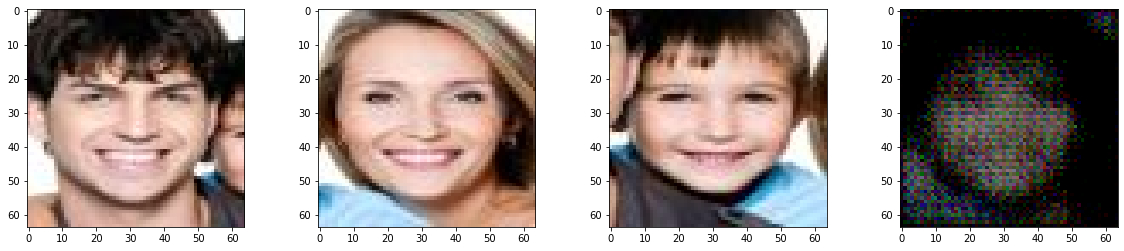

In [71]:
family_no = 1003
family_data = generate_image(all_families[family_no][0], all_families[family_no][1], all_families[family_no][2])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
father_inp = inp[0][tf.newaxis,...]
mother_inp = inp[1][tf.newaxis,...]
noise = tf.random.normal((1,4,4,64),mean= 0.0, stddev=1.0)

with tf.device('/gpu:0'):
    gen_output = supervised([father_inp, mother_inp,noise], training=True)
temp = gen_output.numpy()
fig = plt.figure(figsize=(20, 4))
fig.add_subplot(1,4,1)
plt.imshow(family_data[0])
fig.add_subplot(1,4,2)
plt.imshow(family_data[1])
fig.add_subplot(1,4,3)
plt.imshow(family_data[3])
fig.add_subplot(1,4,4)
plt.imshow(np.squeeze(temp))

###############################################################################################################################

In [17]:
def disc_downsample_parent_target(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(mean, std_dev) 
  

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))

    return result

In [18]:
def disc_loss(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU(alpha = 0.2))
    
    return result

In [19]:
def Discriminator():

    father = tf.keras.layers.Input(shape=(img_size,img_size,3))
    mother = tf.keras.layers.Input(shape=(img_size,img_size,3))
    target = tf.keras.layers.Input(shape=(img_size,img_size,3))
    
    down_stack_parent_target = [
    disc_downsample_parent_target(32,4,apply_batchnorm=False), #32x32x32
    disc_downsample_parent_target(64,4,apply_batchnorm=True)   #16x16x64
    ]
    
    down_stack_combined =[
    disc_loss(192,4,apply_batchnorm=True),
    disc_loss(256,4,apply_batchnorm=False)
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2D(1, 4, strides=1,padding='same',
                                  kernel_initializer=initializer) # linear layer
    
    
    concat = tf.keras.layers.Concatenate()
    x1 = father
    for down in down_stack_parent_target:
        x1 = down(x1)
    
    x2 = mother
    for down in down_stack_parent_target:
        x2 = down(x2)
        
    x3 = target
    for down in down_stack_parent_target:
        x3 = down(x3)
    
    combined = concat([x1,x2,x3])
    # combined is Batchx16x16x192
    
    x4 = combined
    for down in down_stack_combined:
        x4 = down(x4)
#     print(x4.shape)
    
    output = last(x4) #4X4 
    print(output.shape)

    return tf.keras.Model(inputs=[father,mother,target], outputs=output)

In [20]:
# discriminator = Discriminator()
# encoder= EncoderNN()

In [21]:
LAMBDA = 100

In [22]:
kernel_size_disc = 4

In [23]:
def tensor_to_array(tensor1):
    return tensor1.numpy()

In [24]:
def discriminator_loss(disc_real_output, disc_generated_output,b_size):
    real_loss_diff = tf.abs(tf.ones_like(disc_real_output) - disc_real_output)**2
    real_flatten_diff = tf.reshape(real_loss_diff, (b_size, kernel_size_disc*kernel_size_disc*1))
    real_loss_batch = tf.reduce_mean(real_flatten_diff, axis=1)
    real_loss = tf.reduce_mean(real_loss_batch)
    print(real_loss.numpy().shape)
    
    gen_loss_diff = tf.abs(tf.zeros_like(disc_generated_output) - disc_generated_output)**2
    gen_flatten_diff = tf.reshape(gen_loss_diff, (b_size, kernel_size_disc*kernel_size_disc*1))
    gen_loss_batch = tf.reduce_mean(gen_flatten_diff, axis=1)
    gen_loss = tf.reduce_mean(gen_loss_batch)
#     print("gen_loss:",gen_loss)

    total_disc_loss = real_loss + gen_loss
    return total_disc_loss

In [25]:
def generator_loss(disc_generated_output, gen_output, target,b_size):
    gen_loss_diff = tf.abs(tf.ones_like(disc_generated_output) - disc_generated_output)**2
    gen_flatten_diff = tf.reshape(gen_loss_diff, (b_size, kernel_size_disc*kernel_size_disc*1))
    gen_loss_batch = tf.reduce_mean(gen_flatten_diff, axis=1)
    gen_loss = tf.reduce_mean(gen_loss_batch)
    
    l1_loss_diff = tf.abs(target - gen_output)**2
    l1_flatten_diff = tf.reshape(l1_loss_diff, (b_size, img_size*img_size*3))
    l1_loss_batch = tf.reduce_mean(l1_flatten_diff, axis=1)
    l1_loss = tf.reduce_mean(l1_loss_batch)

    
    total_gen_loss = l1_loss + LAMBDA * gen_loss  
#     print("Reconstruction loss: {}, GAN loss: {}".format(l1_loss, gen_loss))
    return total_gen_loss

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=b1 ,beta_2 = b2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta_1=b1, beta_2 = b2)

In [27]:
def train_step(father_batch, mother_batch, noise, target_batch,b_size):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        gen_outputs = unsupervised([father_batch, mother_batch,noise], training=True)
#         print("Generated outputs",gen_outputs.shape)
        
        disc_real_output = discriminator([father_batch, mother_batch, target_batch], training=True)
#         print("disc_real_output ", disc_real_output.shape)
        
        disc_generated_output = discriminator([father_batch, mother_batch, gen_outputs], training=True)
#         print("disc_generated_output ", disc_generated_output.shape)
        
        gen_loss =  generator_loss(disc_generated_output, gen_outputs, target_batch,b_size)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output,b_size)
    
        
    print("GEN_LOSS",tensor_to_array(gen_loss))
    print("DISC_LOSS",tensor_to_array(disc_loss))

    generator_gradients = gen_tape.gradient(gen_loss,unsupervised.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,unsupervised.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

In [28]:
def fit(train_ds, epochs, test_ds,batch):
    for epoch in range(epochs):
        print("______________________________EPOCH %d_______________________________"%(epoch))
        start = time.time()
        for i in range(len(train_ds)//batch):
            batch_data = np.asarray(generate_batch(train_ds[i*batch:(i+1)*batch]))
#             batch_data = batch_data / 255 * 2 -1
            
            print("Generated batch", batch_data.shape)

            X_father_train = tf.convert_to_tensor(batch_data[:,0],dtype =tf.float32)
            X_mother_train = tf.convert_to_tensor(batch_data[:,1],dtype =tf.float32)
            
            noise = tf.random.normal((batch,4,4,64),mean= 0.0, stddev=1.0)
            Y_train = tf.convert_to_tensor(batch_data[:,3],dtype =tf.float32)
            train_step(X_father_train, X_mother_train, noise, Y_train, batch)
            print("Trained for batch %d/%d"%(i+1,(len(train_ds)//batch)))
            
    print("______________________________TRAINING COMPLETED_______________________________")
    checkpoint.save(file_prefix = checkpoint_prefix)

In [29]:
concat = tf.keras.layers.Concatenate()

In [30]:
train_dataset = all_families[:-10]
test_dataset = all_families[-10:]
unsupervised = EncoderNN()
discriminator = Discriminator()

(None, 4, 4, 1)


In [31]:
img_size = 64
mean = 0.
std_dev = 0.02
lr = 0.0005
b1 = 0.9
b2 = 0.99
sd_random_normal_init = 0.02

EPOCHS = 150
batch = 64

In [32]:
checkpoint_dir = './checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=unsupervised,
                                 discriminator=discriminator)

In [117]:
with tf.device('/gpu:0'):
    fit(train_dataset, EPOCHS, test_dataset,batch)

______________________________EPOCH 0_______________________________
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.7549976, shape=(), dtype=float32)
l1_loss: tf.Tensor(19439.8, shape=(), dtype=float32)
()
GEN_LOSS 19515.3
DISC_LOSS 0.91126394
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.6912699, shape=(), dtype=float32)
l1_loss: tf.Tensor(19210.152, shape=(), dtype=float32)
()
GEN_LOSS 19279.28
DISC_LOSS 0.82624257
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.5791348, shape=(), dtype=float32)
l1_loss: tf.Tensor(20992.387, shape=(), dtype=float32)
()
GEN_LOSS 21050.3
DISC_LOSS 0.79787874
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.53746074, shape=(), dtype=float32)
l1_loss: tf.Tensor(20241.418, shape=(), dtype=float32)
()
GEN_LOSS 20295.164
DISC_LOSS 0.7630961
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.48799157, shape=(), dtype=float32

gen_loss: tf.Tensor(0.7432717, shape=(), dtype=float32)
l1_loss: tf.Tensor(20980.043, shape=(), dtype=float32)
()
GEN_LOSS 21054.371
DISC_LOSS 0.27469862
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.75912076, shape=(), dtype=float32)
l1_loss: tf.Tensor(20169.24, shape=(), dtype=float32)
()
GEN_LOSS 20245.152
DISC_LOSS 0.26157755
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.73691314, shape=(), dtype=float32)
l1_loss: tf.Tensor(20342.496, shape=(), dtype=float32)
()
GEN_LOSS 20416.188
DISC_LOSS 0.2752128
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.7558851, shape=(), dtype=float32)
l1_loss: tf.Tensor(19848.635, shape=(), dtype=float32)
()
GEN_LOSS 19924.223
DISC_LOSS 0.24388397
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.7056324, shape=(), dtype=float32)
l1_loss: tf.Tensor(21500.73, shape=(), dtype=float32)
()
GEN_LOSS 21571.293
DISC_LOSS 0.24450

Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.86924505, shape=(), dtype=float32)
l1_loss: tf.Tensor(19200.662, shape=(), dtype=float32)
()
GEN_LOSS 19287.586
DISC_LOSS 0.1489011
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.83011293, shape=(), dtype=float32)
l1_loss: tf.Tensor(20983.586, shape=(), dtype=float32)
()
GEN_LOSS 21066.598
DISC_LOSS 0.15837707
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.85222685, shape=(), dtype=float32)
l1_loss: tf.Tensor(20232.104, shape=(), dtype=float32)
()
GEN_LOSS 20317.326
DISC_LOSS 0.1386385
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.8834451, shape=(), dtype=float32)
l1_loss: tf.Tensor(18503.402, shape=(), dtype=float32)
()
GEN_LOSS 18591.746
DISC_LOSS 0.14347458
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.87268555, shape=(), dtype=float32)
l1_loss: tf.Tensor(20651.691, shape=

Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.92742574, shape=(), dtype=float32)
l1_loss: tf.Tensor(20334.23, shape=(), dtype=float32)
()
GEN_LOSS 20426.973
DISC_LOSS 0.1132526
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.94583803, shape=(), dtype=float32)
l1_loss: tf.Tensor(19840.535, shape=(), dtype=float32)
()
GEN_LOSS 19935.12
DISC_LOSS 0.101125695
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.90272593, shape=(), dtype=float32)
l1_loss: tf.Tensor(21492.34, shape=(), dtype=float32)
()
GEN_LOSS 21582.613
DISC_LOSS 0.105302915
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9273473, shape=(), dtype=float32)
l1_loss: tf.Tensor(19715.035, shape=(), dtype=float32)
()
GEN_LOSS 19807.77
DISC_LOSS 0.107455365
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9303937, shape=(), dtype=float32)
l1_loss: tf.Tensor(19380.762, sh

Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9756001, shape=(), dtype=float32)
l1_loss: tf.Tensor(18496.777, shape=(), dtype=float32)
()
GEN_LOSS 18594.338
DISC_LOSS 0.07799337
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9598239, shape=(), dtype=float32)
l1_loss: tf.Tensor(20645.463, shape=(), dtype=float32)
()
GEN_LOSS 20741.445
DISC_LOSS 0.08699249
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.95663345, shape=(), dtype=float32)
l1_loss: tf.Tensor(19563.576, shape=(), dtype=float32)
()
GEN_LOSS 19659.24
DISC_LOSS 0.075020544
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9906567, shape=(), dtype=float32)
l1_loss: tf.Tensor(19501.898, shape=(), dtype=float32)
()
GEN_LOSS 19600.965
DISC_LOSS 0.078559965
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9823589, shape=(), dtype=float32)
l1_loss: tf.Tensor(20967.99, shape=(

Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9526887, shape=(), dtype=float32)
l1_loss: tf.Tensor(21485.969, shape=(), dtype=float32)
()
GEN_LOSS 21581.238
DISC_LOSS 0.06836672
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9684368, shape=(), dtype=float32)
l1_loss: tf.Tensor(19708.951, shape=(), dtype=float32)
()
GEN_LOSS 19805.795
DISC_LOSS 0.06513471
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9673854, shape=(), dtype=float32)
l1_loss: tf.Tensor(19374.89, shape=(), dtype=float32)
()
GEN_LOSS 19471.629
DISC_LOSS 0.06734153
Trained for batch 15/15
______________________________EPOCH 13_______________________________
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9652971, shape=(), dtype=float32)
l1_loss: tf.Tensor(19419.441, shape=(), dtype=float32)
()
GEN_LOSS 19515.97
DISC_LOSS 0.05820379
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.

DISC_LOSS 0.05060924
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9881763, shape=(), dtype=float32)
l1_loss: tf.Tensor(20640.188, shape=(), dtype=float32)
()
GEN_LOSS 20739.006
DISC_LOSS 0.056569256
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9729384, shape=(), dtype=float32)
l1_loss: tf.Tensor(19557.885, shape=(), dtype=float32)
()
GEN_LOSS 19655.178
DISC_LOSS 0.049766038
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.998819, shape=(), dtype=float32)
l1_loss: tf.Tensor(19496.398, shape=(), dtype=float32)
()
GEN_LOSS 19596.281
DISC_LOSS 0.053301275
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9961933, shape=(), dtype=float32)
l1_loss: tf.Tensor(20962.379, shape=(), dtype=float32)
()
GEN_LOSS 21061.998
DISC_LOSS 0.05164978
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99665284, shape=(), dtype=float32)
l1_loss: tf.Te

gen_loss: tf.Tensor(0.9767152, shape=(), dtype=float32)
l1_loss: tf.Tensor(19703.934, shape=(), dtype=float32)
()
GEN_LOSS 19801.605
DISC_LOSS 0.044247933
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9740445, shape=(), dtype=float32)
l1_loss: tf.Tensor(19370.102, shape=(), dtype=float32)
()
GEN_LOSS 19467.506
DISC_LOSS 0.046554532
Trained for batch 15/15
______________________________EPOCH 18_______________________________
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9797298, shape=(), dtype=float32)
l1_loss: tf.Tensor(19414.408, shape=(), dtype=float32)
()
GEN_LOSS 19512.38
DISC_LOSS 0.042647228
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0141997, shape=(), dtype=float32)
l1_loss: tf.Tensor(19185.617, shape=(), dtype=float32)
()
GEN_LOSS 19287.037
DISC_LOSS 0.043417715
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.97668874, shape=(), dtype=float32)
l1_loss: tf.Tensor(2

Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.97768897, shape=(), dtype=float32)
l1_loss: tf.Tensor(19553.367, shape=(), dtype=float32)
()
GEN_LOSS 19651.137
DISC_LOSS 0.03568123
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99885106, shape=(), dtype=float32)
l1_loss: tf.Tensor(19492.006, shape=(), dtype=float32)
()
GEN_LOSS 19591.89
DISC_LOSS 0.03822415
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0050938, shape=(), dtype=float32)
l1_loss: tf.Tensor(20957.848, shape=(), dtype=float32)
()
GEN_LOSS 21058.357
DISC_LOSS 0.036379747
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.999313, shape=(), dtype=float32)
l1_loss: tf.Tensor(20147.31, shape=(), dtype=float32)
()
GEN_LOSS 20247.242
DISC_LOSS 0.035559684
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.98058414, shape=(), dtype=float32)
l1_loss: tf.Tensor(20320.314, shape=(), dtype=float32)
()


DISC_LOSS 0.03471227
Trained for batch 15/15
______________________________EPOCH 23_______________________________
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99395436, shape=(), dtype=float32)
l1_loss: tf.Tensor(19410.215, shape=(), dtype=float32)
()
GEN_LOSS 19509.61
DISC_LOSS 0.032433476
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.014605, shape=(), dtype=float32)
l1_loss: tf.Tensor(19181.582, shape=(), dtype=float32)
()
GEN_LOSS 19283.043
DISC_LOSS 0.03199269
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9737277, shape=(), dtype=float32)
l1_loss: tf.Tensor(20965.127, shape=(), dtype=float32)
()
GEN_LOSS 21062.5
DISC_LOSS 0.033513587
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9847052, shape=(), dtype=float32)
l1_loss: tf.Tensor(20213.07, shape=(), dtype=float32)
()
GEN_LOSS 20311.541
DISC_LOSS 0.031468734
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen

Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0122101, shape=(), dtype=float32)
l1_loss: tf.Tensor(20953.842, shape=(), dtype=float32)
()
GEN_LOSS 21055.062
DISC_LOSS 0.027404554
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0036943, shape=(), dtype=float32)
l1_loss: tf.Tensor(20143.262, shape=(), dtype=float32)
()
GEN_LOSS 20243.63
DISC_LOSS 0.027928678
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9843844, shape=(), dtype=float32)
l1_loss: tf.Tensor(20316.316, shape=(), dtype=float32)
()
GEN_LOSS 20414.754
DISC_LOSS 0.027860448
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0006251, shape=(), dtype=float32)
l1_loss: tf.Tensor(19822.652, shape=(), dtype=float32)
()
GEN_LOSS 19922.715
DISC_LOSS 0.028242435
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9729036, shape=(), dtype=float32)
l1_loss: tf.Tensor(21473.893, sh

Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0188746, shape=(), dtype=float32)
l1_loss: tf.Tensor(19177.746, shape=(), dtype=float32)
()
GEN_LOSS 19279.633
DISC_LOSS 0.024648525
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9869604, shape=(), dtype=float32)
l1_loss: tf.Tensor(20961.223, shape=(), dtype=float32)
()
GEN_LOSS 21059.918
DISC_LOSS 0.02566729
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9899484, shape=(), dtype=float32)
l1_loss: tf.Tensor(20209.207, shape=(), dtype=float32)
()
GEN_LOSS 20308.201
DISC_LOSS 0.024405625
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9913473, shape=(), dtype=float32)
l1_loss: tf.Tensor(18480.6, shape=(), dtype=float32)
()
GEN_LOSS 18579.734
DISC_LOSS 0.023210555
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99116856, shape=(), dtype=float32)
l1_loss: tf.Tensor(20629.723, shape=

gen_loss: tf.Tensor(1.0024436, shape=(), dtype=float32)
l1_loss: tf.Tensor(20139.352, shape=(), dtype=float32)
()
GEN_LOSS 20239.596
DISC_LOSS 0.022524612
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9879527, shape=(), dtype=float32)
l1_loss: tf.Tensor(20312.518, shape=(), dtype=float32)
()
GEN_LOSS 20411.312
DISC_LOSS 0.02212546
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0040305, shape=(), dtype=float32)
l1_loss: tf.Tensor(19818.924, shape=(), dtype=float32)
()
GEN_LOSS 19919.326
DISC_LOSS 0.022166464
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.980021, shape=(), dtype=float32)
l1_loss: tf.Tensor(21469.934, shape=(), dtype=float32)
()
GEN_LOSS 21567.936
DISC_LOSS 0.022903055
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99722606, shape=(), dtype=float32)
l1_loss: tf.Tensor(19693.531, shape=(), dtype=float32)
()
GEN_LOSS 19793.254
DISC_LOSS 0.

Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9943994, shape=(), dtype=float32)
l1_loss: tf.Tensor(20205.549, shape=(), dtype=float32)
()
GEN_LOSS 20304.988
DISC_LOSS 0.01975168
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9899333, shape=(), dtype=float32)
l1_loss: tf.Tensor(18477.074, shape=(), dtype=float32)
()
GEN_LOSS 18576.068
DISC_LOSS 0.018767951
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9906024, shape=(), dtype=float32)
l1_loss: tf.Tensor(20626.0, shape=(), dtype=float32)
()
GEN_LOSS 20725.06
DISC_LOSS 0.018999385
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9714631, shape=(), dtype=float32)
l1_loss: tf.Tensor(19543.594, shape=(), dtype=float32)
()
GEN_LOSS 19640.74
DISC_LOSS 0.018031992
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9898478, shape=(), dtype=float32)
l1_loss: tf.Tensor(19482.32, shape=(), 

gen_loss: tf.Tensor(1.0026944, shape=(), dtype=float32)
l1_loss: tf.Tensor(19815.438, shape=(), dtype=float32)
()
GEN_LOSS 19915.707
DISC_LOSS 0.017858729
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9886753, shape=(), dtype=float32)
l1_loss: tf.Tensor(21466.193, shape=(), dtype=float32)
()
GEN_LOSS 21565.06
DISC_LOSS 0.018566348
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0014935, shape=(), dtype=float32)
l1_loss: tf.Tensor(19689.965, shape=(), dtype=float32)
()
GEN_LOSS 19790.113
DISC_LOSS 0.01788753
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9859083, shape=(), dtype=float32)
l1_loss: tf.Tensor(19356.55, shape=(), dtype=float32)
()
GEN_LOSS 19455.143
DISC_LOSS 0.018874293
Trained for batch 15/15
______________________________EPOCH 36_______________________________
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0074959, shape=(), dtype=float32)
l1_loss: tf.Tensor(19

gen_loss: tf.Tensor(0.98090506, shape=(), dtype=float32)
l1_loss: tf.Tensor(18473.902, shape=(), dtype=float32)
()
GEN_LOSS 18571.992
DISC_LOSS 0.01599232
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.98938334, shape=(), dtype=float32)
l1_loss: tf.Tensor(20622.443, shape=(), dtype=float32)
()
GEN_LOSS 20721.38
DISC_LOSS 0.015637241
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.97225654, shape=(), dtype=float32)
l1_loss: tf.Tensor(19540.314, shape=(), dtype=float32)
()
GEN_LOSS 19637.541
DISC_LOSS 0.014848617
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99930584, shape=(), dtype=float32)
l1_loss: tf.Tensor(19478.965, shape=(), dtype=float32)
()
GEN_LOSS 19578.895
DISC_LOSS 0.016175382
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0164043, shape=(), dtype=float32)
l1_loss: tf.Tensor(20944.426, shape=(), dtype=float32)
()
GEN_LOSS 21046.066
DISC_LOSS 0.0

gen_loss: tf.Tensor(0.9844579, shape=(), dtype=float32)
l1_loss: tf.Tensor(21462.707, shape=(), dtype=float32)
()
GEN_LOSS 21561.152
DISC_LOSS 0.0151899215
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.004811, shape=(), dtype=float32)
l1_loss: tf.Tensor(19686.605, shape=(), dtype=float32)
()
GEN_LOSS 19787.086
DISC_LOSS 0.014758006
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9900302, shape=(), dtype=float32)
l1_loss: tf.Tensor(19353.293, shape=(), dtype=float32)
()
GEN_LOSS 19452.297
DISC_LOSS 0.015723161
Trained for batch 15/15
______________________________EPOCH 41_______________________________
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0120437, shape=(), dtype=float32)
l1_loss: tf.Tensor(19397.273, shape=(), dtype=float32)
()
GEN_LOSS 19498.479
DISC_LOSS 0.015544505
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0170794, shape=(), dtype=float32)
l1_loss: tf.Tensor(

Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9905529, shape=(), dtype=float32)
l1_loss: tf.Tensor(20619.008, shape=(), dtype=float32)
()
GEN_LOSS 20718.062
DISC_LOSS 0.012866791
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9721083, shape=(), dtype=float32)
l1_loss: tf.Tensor(19537.258, shape=(), dtype=float32)
()
GEN_LOSS 19634.469
DISC_LOSS 0.012343098
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99769616, shape=(), dtype=float32)
l1_loss: tf.Tensor(19475.758, shape=(), dtype=float32)
()
GEN_LOSS 19575.527
DISC_LOSS 0.01358933
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0208275, shape=(), dtype=float32)
l1_loss: tf.Tensor(20941.094, shape=(), dtype=float32)
()
GEN_LOSS 21043.176
DISC_LOSS 0.013101756
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9997388, shape=(), dtype=float32)
l1_loss: tf.Tensor(20130.371, shap

Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.995175, shape=(), dtype=float32)
l1_loss: tf.Tensor(19350.023, shape=(), dtype=float32)
()
GEN_LOSS 19449.541
DISC_LOSS 0.012909317
Trained for batch 15/15
______________________________EPOCH 46_______________________________
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0179939, shape=(), dtype=float32)
l1_loss: tf.Tensor(19394.045, shape=(), dtype=float32)
()
GEN_LOSS 19495.844
DISC_LOSS 0.013168581
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0171876, shape=(), dtype=float32)
l1_loss: tf.Tensor(19165.613, shape=(), dtype=float32)
()
GEN_LOSS 19267.332
DISC_LOSS 0.012902626
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9922248, shape=(), dtype=float32)
l1_loss: tf.Tensor(20948.457, shape=(), dtype=float32)
()
GEN_LOSS 21047.68
DISC_LOSS 0.012000097
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(

gen_loss: tf.Tensor(0.99560106, shape=(), dtype=float32)
l1_loss: tf.Tensor(19472.38, shape=(), dtype=float32)
()
GEN_LOSS 19571.941
DISC_LOSS 0.011162464
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0242574, shape=(), dtype=float32)
l1_loss: tf.Tensor(20937.605, shape=(), dtype=float32)
()
GEN_LOSS 21040.031
DISC_LOSS 0.010743678
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.006455, shape=(), dtype=float32)
l1_loss: tf.Tensor(20126.922, shape=(), dtype=float32)
()
GEN_LOSS 20227.566
DISC_LOSS 0.011337082
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99416274, shape=(), dtype=float32)
l1_loss: tf.Tensor(20300.416, shape=(), dtype=float32)
()
GEN_LOSS 20399.832
DISC_LOSS 0.010594057
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9918217, shape=(), dtype=float32)
l1_loss: tf.Tensor(19806.98, shape=(), dtype=float32)
()
GEN_LOSS 19906.162
DISC_LOSS 0.01

gen_loss: tf.Tensor(1.0144105, shape=(), dtype=float32)
l1_loss: tf.Tensor(19390.547, shape=(), dtype=float32)
()
GEN_LOSS 19491.988
DISC_LOSS 0.0108716665
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0134254, shape=(), dtype=float32)
l1_loss: tf.Tensor(19162.133, shape=(), dtype=float32)
()
GEN_LOSS 19263.475
DISC_LOSS 0.010962624
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99317753, shape=(), dtype=float32)
l1_loss: tf.Tensor(20944.766, shape=(), dtype=float32)
()
GEN_LOSS 21044.084
DISC_LOSS 0.009949713
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9930612, shape=(), dtype=float32)
l1_loss: tf.Tensor(20193.414, shape=(), dtype=float32)
()
GEN_LOSS 20292.72
DISC_LOSS 0.010114944
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9737928, shape=(), dtype=float32)
l1_loss: tf.Tensor(18465.727, shape=(), dtype=float32)
()
GEN_LOSS 18563.105
DISC_LOSS 0.01

gen_loss: tf.Tensor(1.022758, shape=(), dtype=float32)
l1_loss: tf.Tensor(20933.975, shape=(), dtype=float32)
()
GEN_LOSS 21036.25
DISC_LOSS 0.009076793
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.009794, shape=(), dtype=float32)
l1_loss: tf.Tensor(20123.312, shape=(), dtype=float32)
()
GEN_LOSS 20224.291
DISC_LOSS 0.009744398
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.996214, shape=(), dtype=float32)
l1_loss: tf.Tensor(20296.82, shape=(), dtype=float32)
()
GEN_LOSS 20396.441
DISC_LOSS 0.008858316
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9950632, shape=(), dtype=float32)
l1_loss: tf.Tensor(19803.488, shape=(), dtype=float32)
()
GEN_LOSS 19902.994
DISC_LOSS 0.008870919
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99955714, shape=(), dtype=float32)
l1_loss: tf.Tensor(21453.291, shape=(), dtype=float32)
()
GEN_LOSS 21553.246
DISC_LOSS 0.0094

Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0137948, shape=(), dtype=float32)
l1_loss: tf.Tensor(19158.707, shape=(), dtype=float32)
()
GEN_LOSS 19260.086
DISC_LOSS 0.009336786
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.998906, shape=(), dtype=float32)
l1_loss: tf.Tensor(20941.074, shape=(), dtype=float32)
()
GEN_LOSS 21040.965
DISC_LOSS 0.008238271
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9968241, shape=(), dtype=float32)
l1_loss: tf.Tensor(20189.926, shape=(), dtype=float32)
()
GEN_LOSS 20289.607
DISC_LOSS 0.008497285
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9688417, shape=(), dtype=float32)
l1_loss: tf.Tensor(18462.469, shape=(), dtype=float32)
()
GEN_LOSS 18559.354
DISC_LOSS 0.008691461
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9892516, shape=(), dtype=float32)
l1_loss: tf.Tensor(20609.582, shape

Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9968127, shape=(), dtype=float32)
l1_loss: tf.Tensor(20293.254, shape=(), dtype=float32)
()
GEN_LOSS 20392.936
DISC_LOSS 0.0074658142
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9905404, shape=(), dtype=float32)
l1_loss: tf.Tensor(19800.016, shape=(), dtype=float32)
()
GEN_LOSS 19899.07
DISC_LOSS 0.007397083
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99844337, shape=(), dtype=float32)
l1_loss: tf.Tensor(21449.55, shape=(), dtype=float32)
()
GEN_LOSS 21549.395
DISC_LOSS 0.008193574
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.00684, shape=(), dtype=float32)
l1_loss: tf.Tensor(19674.121, shape=(), dtype=float32)
()
GEN_LOSS 19774.805
DISC_LOSS 0.008043904
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0012949, shape=(), dtype=float32)
l1_loss: tf.Tensor(19341.016, s

Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9995896, shape=(), dtype=float32)
l1_loss: tf.Tensor(20186.545, shape=(), dtype=float32)
()
GEN_LOSS 20286.504
DISC_LOSS 0.007290194
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.96527743, shape=(), dtype=float32)
l1_loss: tf.Tensor(18459.207, shape=(), dtype=float32)
()
GEN_LOSS 18555.734
DISC_LOSS 0.0076134736
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9860501, shape=(), dtype=float32)
l1_loss: tf.Tensor(20606.01, shape=(), dtype=float32)
()
GEN_LOSS 20704.615
DISC_LOSS 0.0074186977
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9572653, shape=(), dtype=float32)
l1_loss: tf.Tensor(19525.254, shape=(), dtype=float32)
()
GEN_LOSS 19620.98
DISC_LOSS 0.007402108
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9955751, shape=(), dtype=float32)
l1_loss: tf.Tensor(19463.41, shape=(), dtype=float32)
()

gen_loss: tf.Tensor(0.99235195, shape=(), dtype=float32)
l1_loss: tf.Tensor(19796.559, shape=(), dtype=float32)
()
GEN_LOSS 19895.793
DISC_LOSS 0.006486845
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9894368, shape=(), dtype=float32)
l1_loss: tf.Tensor(21445.922, shape=(), dtype=float32)
()
GEN_LOSS 21544.865
DISC_LOSS 0.0073488643
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9935051, shape=(), dtype=float32)
l1_loss: tf.Tensor(19670.63, shape=(), dtype=float32)
()
GEN_LOSS 19769.98
DISC_LOSS 0.007207066
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.98960495, shape=(), dtype=float32)
l1_loss: tf.Tensor(19337.592, shape=(), dtype=float32)
()
GEN_LOSS 19436.553
DISC_LOSS 0.0075763897
Trained for batch 15/15
______________________________EPOCH 64_______________________________
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0118625, shape=(), dtype=float32)
l1_loss: tf.Tens

gen_loss: tf.Tensor(0.9830624, shape=(), dtype=float32)
l1_loss: tf.Tensor(18455.953, shape=(), dtype=float32)
()
GEN_LOSS 18554.26
DISC_LOSS 0.006490318
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9647225, shape=(), dtype=float32)
l1_loss: tf.Tensor(20602.404, shape=(), dtype=float32)
()
GEN_LOSS 20698.877
DISC_LOSS 0.007018444
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9184706, shape=(), dtype=float32)
l1_loss: tf.Tensor(19521.932, shape=(), dtype=float32)
()
GEN_LOSS 19613.78
DISC_LOSS 0.008529134
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.95377755, shape=(), dtype=float32)
l1_loss: tf.Tensor(19459.992, shape=(), dtype=float32)
()
GEN_LOSS 19555.37
DISC_LOSS 0.007500385
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0157695, shape=(), dtype=float32)
l1_loss: tf.Tensor(20924.73, shape=(), dtype=float32)
()
GEN_LOSS 21026.307
DISC_LOSS 0.006445

Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0727533, shape=(), dtype=float32)
l1_loss: tf.Tensor(19667.076, shape=(), dtype=float32)
()
GEN_LOSS 19774.352
DISC_LOSS 0.00846673
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0320715, shape=(), dtype=float32)
l1_loss: tf.Tensor(19334.043, shape=(), dtype=float32)
()
GEN_LOSS 19437.25
DISC_LOSS 0.0072612325
Trained for batch 15/15
______________________________EPOCH 69_______________________________
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0005808, shape=(), dtype=float32)
l1_loss: tf.Tensor(19378.264, shape=(), dtype=float32)
()
GEN_LOSS 19478.322
DISC_LOSS 0.0071642124
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9652274, shape=(), dtype=float32)
l1_loss: tf.Tensor(19150.055, shape=(), dtype=float32)
()
GEN_LOSS 19246.578
DISC_LOSS 0.0083633475
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9695482, shape=(),

Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.97799504, shape=(), dtype=float32)
l1_loss: tf.Tensor(19456.418, shape=(), dtype=float32)
()
GEN_LOSS 19554.217
DISC_LOSS 0.006375404
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.98760736, shape=(), dtype=float32)
l1_loss: tf.Tensor(20921.125, shape=(), dtype=float32)
()
GEN_LOSS 21019.885
DISC_LOSS 0.006040211
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.96740687, shape=(), dtype=float32)
l1_loss: tf.Tensor(20110.438, shape=(), dtype=float32)
()
GEN_LOSS 20207.178
DISC_LOSS 0.008103001
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9756595, shape=(), dtype=float32)
l1_loss: tf.Tensor(20283.928, shape=(), dtype=float32)
()
GEN_LOSS 20381.494
DISC_LOSS 0.00725359
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.986467, shape=(), dtype=float32)
l1_loss: tf.Tensor(19790.877, s

gen_loss: tf.Tensor(0.98222363, shape=(), dtype=float32)
l1_loss: tf.Tensor(19374.691, shape=(), dtype=float32)
()
GEN_LOSS 19472.914
DISC_LOSS 0.006625224
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.98368585, shape=(), dtype=float32)
l1_loss: tf.Tensor(19146.559, shape=(), dtype=float32)
()
GEN_LOSS 19244.928
DISC_LOSS 0.0068091406
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9994775, shape=(), dtype=float32)
l1_loss: tf.Tensor(20927.762, shape=(), dtype=float32)
()
GEN_LOSS 21027.709
DISC_LOSS 0.0061543975
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.025025, shape=(), dtype=float32)
l1_loss: tf.Tensor(20177.27, shape=(), dtype=float32)
()
GEN_LOSS 20279.771
DISC_LOSS 0.0068690665
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0107819, shape=(), dtype=float32)
l1_loss: tf.Tensor(18450.424, shape=(), dtype=float32)
()
GEN_LOSS 18551.502
DISC_LOSS 0.

Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0059129, shape=(), dtype=float32)
l1_loss: tf.Tensor(20917.531, shape=(), dtype=float32)
()
GEN_LOSS 21018.123
DISC_LOSS 0.0062621976
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9863987, shape=(), dtype=float32)
l1_loss: tf.Tensor(20106.89, shape=(), dtype=float32)
()
GEN_LOSS 20205.531
DISC_LOSS 0.006534709
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.98509264, shape=(), dtype=float32)
l1_loss: tf.Tensor(20280.422, shape=(), dtype=float32)
()
GEN_LOSS 20378.932
DISC_LOSS 0.005908514
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9879875, shape=(), dtype=float32)
l1_loss: tf.Tensor(19787.46, shape=(), dtype=float32)
()
GEN_LOSS 19886.26
DISC_LOSS 0.0065236455
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0057311, shape=(), dtype=float32)
l1_loss: tf.Tensor(21436.254, shape=(), dtype=float32)

Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9768374, shape=(), dtype=float32)
l1_loss: tf.Tensor(19143.1, shape=(), dtype=float32)
()
GEN_LOSS 19240.783
DISC_LOSS 0.0061432295
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99111515, shape=(), dtype=float32)
l1_loss: tf.Tensor(20924.016, shape=(), dtype=float32)
()
GEN_LOSS 21023.127
DISC_LOSS 0.0054740645
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0194039, shape=(), dtype=float32)
l1_loss: tf.Tensor(20173.727, shape=(), dtype=float32)
()
GEN_LOSS 20275.666
DISC_LOSS 0.0059479875
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0087361, shape=(), dtype=float32)
l1_loss: tf.Tensor(18447.078, shape=(), dtype=float32)
()
GEN_LOSS 18547.951
DISC_LOSS 0.006819527
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.034226, shape=(), dtype=float32)
l1_loss: tf.Tensor(20592.703, sha

GEN_LOSS 20202.822
DISC_LOSS 0.005674603
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9957688, shape=(), dtype=float32)
l1_loss: tf.Tensor(20276.855, shape=(), dtype=float32)
()
GEN_LOSS 20376.432
DISC_LOSS 0.0052077747
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99562323, shape=(), dtype=float32)
l1_loss: tf.Tensor(19783.906, shape=(), dtype=float32)
()
GEN_LOSS 19883.469
DISC_LOSS 0.0058224765
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0034156, shape=(), dtype=float32)
l1_loss: tf.Tensor(21432.5, shape=(), dtype=float32)
()
GEN_LOSS 21532.842
DISC_LOSS 0.0066193365
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99669194, shape=(), dtype=float32)
l1_loss: tf.Tensor(19657.797, shape=(), dtype=float32)
()
GEN_LOSS 19757.467
DISC_LOSS 0.006396241
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9804429, shape=(), 

gen_loss: tf.Tensor(0.9892735, shape=(), dtype=float32)
l1_loss: tf.Tensor(20920.215, shape=(), dtype=float32)
()
GEN_LOSS 21019.143
DISC_LOSS 0.005045336
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0186143, shape=(), dtype=float32)
l1_loss: tf.Tensor(20170.055, shape=(), dtype=float32)
()
GEN_LOSS 20271.916
DISC_LOSS 0.005370955
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0068967, shape=(), dtype=float32)
l1_loss: tf.Tensor(18443.57, shape=(), dtype=float32)
()
GEN_LOSS 18544.26
DISC_LOSS 0.0059514362
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0302271, shape=(), dtype=float32)
l1_loss: tf.Tensor(20588.941, shape=(), dtype=float32)
()
GEN_LOSS 20691.965
DISC_LOSS 0.006155111
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99245083, shape=(), dtype=float32)
l1_loss: tf.Tensor(19509.438, shape=(), dtype=float32)
()
GEN_LOSS 19608.682
DISC_LOSS 0.006

Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.998697, shape=(), dtype=float32)
l1_loss: tf.Tensor(19780.375, shape=(), dtype=float32)
()
GEN_LOSS 19880.244
DISC_LOSS 0.004990247
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0068088, shape=(), dtype=float32)
l1_loss: tf.Tensor(21428.828, shape=(), dtype=float32)
()
GEN_LOSS 21529.51
DISC_LOSS 0.005794758
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99660194, shape=(), dtype=float32)
l1_loss: tf.Tensor(19654.225, shape=(), dtype=float32)
()
GEN_LOSS 19753.885
DISC_LOSS 0.005469692
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.97903407, shape=(), dtype=float32)
l1_loss: tf.Tensor(19321.229, shape=(), dtype=float32)
()
GEN_LOSS 19419.133
DISC_LOSS 0.0058601885
Trained for batch 15/15
______________________________EPOCH 87_______________________________
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9798603, shape=(

Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99794734, shape=(), dtype=float32)
l1_loss: tf.Tensor(18440.066, shape=(), dtype=float32)
()
GEN_LOSS 18539.861
DISC_LOSS 0.005239868
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0262868, shape=(), dtype=float32)
l1_loss: tf.Tensor(20585.102, shape=(), dtype=float32)
()
GEN_LOSS 20687.73
DISC_LOSS 0.00540623
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.98660076, shape=(), dtype=float32)
l1_loss: tf.Tensor(19505.908, shape=(), dtype=float32)
()
GEN_LOSS 19604.568
DISC_LOSS 0.0055330913
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99472433, shape=(), dtype=float32)
l1_loss: tf.Tensor(19443.637, shape=(), dtype=float32)
()
GEN_LOSS 19543.11
DISC_LOSS 0.0051996587
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0155573, shape=(), dtype=float32)
l1_loss: tf.Tensor(20908.092, sh

gen_loss: tf.Tensor(1.0055804, shape=(), dtype=float32)
l1_loss: tf.Tensor(21425.146, shape=(), dtype=float32)
()
GEN_LOSS 21525.705
DISC_LOSS 0.0051675593
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9981302, shape=(), dtype=float32)
l1_loss: tf.Tensor(19650.668, shape=(), dtype=float32)
()
GEN_LOSS 19750.48
DISC_LOSS 0.004956901
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.97680485, shape=(), dtype=float32)
l1_loss: tf.Tensor(19317.678, shape=(), dtype=float32)
()
GEN_LOSS 19415.357
DISC_LOSS 0.005273276
Trained for batch 15/15
______________________________EPOCH 92_______________________________
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9856756, shape=(), dtype=float32)
l1_loss: tf.Tensor(19362.342, shape=(), dtype=float32)
()
GEN_LOSS 19460.91
DISC_LOSS 0.00506707
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.98185575, shape=(), dtype=float32)
l1_loss: tf.Tensor(

gen_loss: tf.Tensor(1.0176955, shape=(), dtype=float32)
l1_loss: tf.Tensor(20581.445, shape=(), dtype=float32)
()
GEN_LOSS 20683.215
DISC_LOSS 0.0048025814
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9866318, shape=(), dtype=float32)
l1_loss: tf.Tensor(19502.406, shape=(), dtype=float32)
()
GEN_LOSS 19601.07
DISC_LOSS 0.004942175
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9967796, shape=(), dtype=float32)
l1_loss: tf.Tensor(19440.076, shape=(), dtype=float32)
()
GEN_LOSS 19539.754
DISC_LOSS 0.0044273594
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0123067, shape=(), dtype=float32)
l1_loss: tf.Tensor(20904.348, shape=(), dtype=float32)
()
GEN_LOSS 21005.578
DISC_LOSS 0.004115275
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0104785, shape=(), dtype=float32)
l1_loss: tf.Tensor(20093.707, shape=(), dtype=float32)
()
GEN_LOSS 20194.754
DISC_LOSS 0.00

gen_loss: tf.Tensor(0.9991594, shape=(), dtype=float32)
l1_loss: tf.Tensor(19646.93, shape=(), dtype=float32)
()
GEN_LOSS 19746.846
DISC_LOSS 0.004368011
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9846733, shape=(), dtype=float32)
l1_loss: tf.Tensor(19313.994, shape=(), dtype=float32)
()
GEN_LOSS 19412.46
DISC_LOSS 0.004471174
Trained for batch 15/15
______________________________EPOCH 97_______________________________
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9850487, shape=(), dtype=float32)
l1_loss: tf.Tensor(19358.814, shape=(), dtype=float32)
()
GEN_LOSS 19457.318
DISC_LOSS 0.004426296
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9802586, shape=(), dtype=float32)
l1_loss: tf.Tensor(19130.582, shape=(), dtype=float32)
()
GEN_LOSS 19228.607
DISC_LOSS 0.004791625
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9945659, shape=(), dtype=float32)
l1_loss: tf.Tensor(209

gen_loss: tf.Tensor(0.9799523, shape=(), dtype=float32)
l1_loss: tf.Tensor(19498.762, shape=(), dtype=float32)
()
GEN_LOSS 19596.758
DISC_LOSS 0.0043565556
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99093974, shape=(), dtype=float32)
l1_loss: tf.Tensor(19436.3, shape=(), dtype=float32)
()
GEN_LOSS 19535.395
DISC_LOSS 0.004020093
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0179726, shape=(), dtype=float32)
l1_loss: tf.Tensor(20900.42, shape=(), dtype=float32)
()
GEN_LOSS 21002.217
DISC_LOSS 0.0038083303
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0138686, shape=(), dtype=float32)
l1_loss: tf.Tensor(20089.805, shape=(), dtype=float32)
()
GEN_LOSS 20191.191
DISC_LOSS 0.0039244676
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0039487, shape=(), dtype=float32)
l1_loss: tf.Tensor(20263.436, shape=(), dtype=float32)
()
GEN_LOSS 20363.83
DISC_LOSS 0.00

gen_loss: tf.Tensor(0.98695314, shape=(), dtype=float32)
l1_loss: tf.Tensor(19310.31, shape=(), dtype=float32)
()
GEN_LOSS 19409.006
DISC_LOSS 0.0039729998
Trained for batch 15/15
______________________________EPOCH 102_______________________________
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99177325, shape=(), dtype=float32)
l1_loss: tf.Tensor(19355.176, shape=(), dtype=float32)
()
GEN_LOSS 19454.354
DISC_LOSS 0.0039382363
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9888389, shape=(), dtype=float32)
l1_loss: tf.Tensor(19126.865, shape=(), dtype=float32)
()
GEN_LOSS 19225.75
DISC_LOSS 0.0044480027
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9933258, shape=(), dtype=float32)
l1_loss: tf.Tensor(20906.639, shape=(), dtype=float32)
()
GEN_LOSS 21005.97
DISC_LOSS 0.0036827193
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0042039, shape=(), dtype=float32)
l1_loss: tf.Tenso

Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.98804367, shape=(), dtype=float32)
l1_loss: tf.Tensor(19351.229, shape=(), dtype=float32)
()
GEN_LOSS 19450.033
DISC_LOSS 0.0036041124
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9868809, shape=(), dtype=float32)
l1_loss: tf.Tensor(19122.87, shape=(), dtype=float32)
()
GEN_LOSS 19221.557
DISC_LOSS 0.0038278117
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0005754, shape=(), dtype=float32)
l1_loss: tf.Tensor(20902.465, shape=(), dtype=float32)
()
GEN_LOSS 21002.521
DISC_LOSS 0.0033087078
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0072532, shape=(), dtype=float32)
l1_loss: tf.Tensor(20152.566, shape=(), dtype=float32)
()
GEN_LOSS 20253.291
DISC_LOSS 0.0034521194
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.97777593, shape=(), dtype=float32)
l1_loss: tf.Tensor(18426.951, shape=(), dtype=float3

gen_loss: tf.Tensor(1.0224102, shape=(), dtype=float32)
l1_loss: tf.Tensor(20892.262, shape=(), dtype=float32)
()
GEN_LOSS 20994.502
DISC_LOSS 0.0030858037
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0196909, shape=(), dtype=float32)
l1_loss: tf.Tensor(20081.754, shape=(), dtype=float32)
()
GEN_LOSS 20183.723
DISC_LOSS 0.0033811703
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0076106, shape=(), dtype=float32)
l1_loss: tf.Tensor(20255.262, shape=(), dtype=float32)
()
GEN_LOSS 20356.023
DISC_LOSS 0.0032077245
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9920959, shape=(), dtype=float32)
l1_loss: tf.Tensor(19762.762, shape=(), dtype=float32)
()
GEN_LOSS 19861.97
DISC_LOSS 0.0029822914
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0091314, shape=(), dtype=float32)
l1_loss: tf.Tensor(21410.742, shape=(), dtype=float32)
()
GEN_LOSS 21511.656
DISC_LOSS

Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.97678494, shape=(), dtype=float32)
l1_loss: tf.Tensor(19119.1, shape=(), dtype=float32)
()
GEN_LOSS 19216.777
DISC_LOSS 0.0035916714
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99400175, shape=(), dtype=float32)
l1_loss: tf.Tensor(20898.49, shape=(), dtype=float32)
()
GEN_LOSS 20997.89
DISC_LOSS 0.00304284
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0102607, shape=(), dtype=float32)
l1_loss: tf.Tensor(20148.621, shape=(), dtype=float32)
()
GEN_LOSS 20249.646
DISC_LOSS 0.0031327908
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9884738, shape=(), dtype=float32)
l1_loss: tf.Tensor(18423.148, shape=(), dtype=float32)
()
GEN_LOSS 18521.996
DISC_LOSS 0.0033141682
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0100402, shape=(), dtype=float32)
l1_loss: tf.Tensor(20567.121, shap

Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0251229, shape=(), dtype=float32)
l1_loss: tf.Tensor(20077.787, shape=(), dtype=float32)
()
GEN_LOSS 20180.299
DISC_LOSS 0.0030996138
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0135493, shape=(), dtype=float32)
l1_loss: tf.Tensor(20251.346, shape=(), dtype=float32)
()
GEN_LOSS 20352.701
DISC_LOSS 0.0028478722
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9924129, shape=(), dtype=float32)
l1_loss: tf.Tensor(19758.973, shape=(), dtype=float32)
()
GEN_LOSS 19858.215
DISC_LOSS 0.0027254026
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9985658, shape=(), dtype=float32)
l1_loss: tf.Tensor(21406.832, shape=(), dtype=float32)
()
GEN_LOSS 21506.69
DISC_LOSS 0.0032548388
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0044639, shape=(), dtype=float32)
l1_loss: tf.Tensor(19633.006, shape=(), dtype=floa

l1_loss: tf.Tensor(20894.525, shape=(), dtype=float32)
()
GEN_LOSS 20992.432
DISC_LOSS 0.0029251422
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99038833, shape=(), dtype=float32)
l1_loss: tf.Tensor(20144.688, shape=(), dtype=float32)
()
GEN_LOSS 20243.727
DISC_LOSS 0.002957316
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9881441, shape=(), dtype=float32)
l1_loss: tf.Tensor(18419.47, shape=(), dtype=float32)
()
GEN_LOSS 18518.285
DISC_LOSS 0.0030551883
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0352322, shape=(), dtype=float32)
l1_loss: tf.Tensor(20563.242, shape=(), dtype=float32)
()
GEN_LOSS 20666.766
DISC_LOSS 0.0033461046
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99082553, shape=(), dtype=float32)
l1_loss: tf.Tensor(19484.69, shape=(), dtype=float32)
()
GEN_LOSS 19583.771
DISC_LOSS 0.0028423264
Trained for batch 7/15
Generated batch (64, 4

gen_loss: tf.Tensor(1.0125152, shape=(), dtype=float32)
l1_loss: tf.Tensor(20247.443, shape=(), dtype=float32)
()
GEN_LOSS 20348.695
DISC_LOSS 0.0026959456
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0003846, shape=(), dtype=float32)
l1_loss: tf.Tensor(19755.115, shape=(), dtype=float32)
()
GEN_LOSS 19855.154
DISC_LOSS 0.0025715102
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0072939, shape=(), dtype=float32)
l1_loss: tf.Tensor(21402.824, shape=(), dtype=float32)
()
GEN_LOSS 21503.553
DISC_LOSS 0.0030088231
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99928045, shape=(), dtype=float32)
l1_loss: tf.Tensor(19629.166, shape=(), dtype=float32)
()
GEN_LOSS 19729.094
DISC_LOSS 0.002634329
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.98905706, shape=(), dtype=float32)
l1_loss: tf.Tensor(19296.426, shape=(), dtype=float32)
()
GEN_LOSS 19395.332
DISC_L

Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9905322, shape=(), dtype=float32)
l1_loss: tf.Tensor(18415.777, shape=(), dtype=float32)
()
GEN_LOSS 18514.83
DISC_LOSS 0.0027841413
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0051484, shape=(), dtype=float32)
l1_loss: tf.Tensor(20559.29, shape=(), dtype=float32)
()
GEN_LOSS 20659.805
DISC_LOSS 0.0025729565
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9721806, shape=(), dtype=float32)
l1_loss: tf.Tensor(19480.848, shape=(), dtype=float32)
()
GEN_LOSS 19578.066
DISC_LOSS 0.0029450138
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9858247, shape=(), dtype=float32)
l1_loss: tf.Tensor(19418.396, shape=(), dtype=float32)
()
GEN_LOSS 19516.979
DISC_LOSS 0.002610288
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0064564, shape=(), dtype=float32)
l1_loss: tf.Tensor(20882.06, shap

Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0045433, shape=(), dtype=float32)
l1_loss: tf.Tensor(19625.416, shape=(), dtype=float32)
()
GEN_LOSS 19725.871
DISC_LOSS 0.0025537265
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.98866457, shape=(), dtype=float32)
l1_loss: tf.Tensor(19292.695, shape=(), dtype=float32)
()
GEN_LOSS 19391.562
DISC_LOSS 0.0025856523
Trained for batch 15/15
______________________________EPOCH 125_______________________________
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9868194, shape=(), dtype=float32)
l1_loss: tf.Tensor(19337.682, shape=(), dtype=float32)
()
GEN_LOSS 19436.363
DISC_LOSS 0.002718655
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.98018914, shape=(), dtype=float32)
l1_loss: tf.Tensor(19109.523, shape=(), dtype=float32)
()
GEN_LOSS 19207.543
DISC_LOSS 0.002912993
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf

Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.97620404, shape=(), dtype=float32)
l1_loss: tf.Tensor(19477.186, shape=(), dtype=float32)
()
GEN_LOSS 19574.807
DISC_LOSS 0.002630277
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.98955166, shape=(), dtype=float32)
l1_loss: tf.Tensor(19414.71, shape=(), dtype=float32)
()
GEN_LOSS 19513.666
DISC_LOSS 0.0023949323
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0064973, shape=(), dtype=float32)
l1_loss: tf.Tensor(20878.277, shape=(), dtype=float32)
()
GEN_LOSS 20978.928
DISC_LOSS 0.0022995984
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.011941, shape=(), dtype=float32)
l1_loss: tf.Tensor(20067.95, shape=(), dtype=float32)
()
GEN_LOSS 20169.143
DISC_LOSS 0.0024983564
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0079315, shape=(), dtype=float32)
l1_loss: tf.Tensor(20241.432, s

gen_loss: tf.Tensor(0.9921533, shape=(), dtype=float32)
l1_loss: tf.Tensor(19289.11, shape=(), dtype=float32)
()
GEN_LOSS 19388.324
DISC_LOSS 0.0023496686
Trained for batch 15/15
______________________________EPOCH 130_______________________________
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9845763, shape=(), dtype=float32)
l1_loss: tf.Tensor(19334.203, shape=(), dtype=float32)
()
GEN_LOSS 19432.66
DISC_LOSS 0.0025348589
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9819255, shape=(), dtype=float32)
l1_loss: tf.Tensor(19106.027, shape=(), dtype=float32)
()
GEN_LOSS 19204.22
DISC_LOSS 0.0027704365
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99820507, shape=(), dtype=float32)
l1_loss: tf.Tensor(20884.59, shape=(), dtype=float32)
()
GEN_LOSS 20984.41
DISC_LOSS 0.0022897113
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.013139, shape=(), dtype=float32)
l1_loss: tf.Tensor(20

gen_loss: tf.Tensor(0.9823518, shape=(), dtype=float32)
l1_loss: tf.Tensor(19411.191, shape=(), dtype=float32)
()
GEN_LOSS 19509.426
DISC_LOSS 0.0023466013
Trained for batch 8/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99834204, shape=(), dtype=float32)
l1_loss: tf.Tensor(20874.652, shape=(), dtype=float32)
()
GEN_LOSS 20974.486
DISC_LOSS 0.0021249847
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.008354, shape=(), dtype=float32)
l1_loss: tf.Tensor(20064.297, shape=(), dtype=float32)
()
GEN_LOSS 20165.133
DISC_LOSS 0.0022870912
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0164218, shape=(), dtype=float32)
l1_loss: tf.Tensor(20237.836, shape=(), dtype=float32)
()
GEN_LOSS 20339.479
DISC_LOSS 0.0023309086
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0119027, shape=(), dtype=float32)
l1_loss: tf.Tensor(19745.676, shape=(), dtype=float32)
()
GEN_LOSS 19846.865
DISC_LOSS

Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.98388577, shape=(), dtype=float32)
l1_loss: tf.Tensor(19330.65, shape=(), dtype=float32)
()
GEN_LOSS 19429.04
DISC_LOSS 0.0026979998
Trained for batch 1/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.97880924, shape=(), dtype=float32)
l1_loss: tf.Tensor(19102.494, shape=(), dtype=float32)
()
GEN_LOSS 19200.375
DISC_LOSS 0.0027858182
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.006492, shape=(), dtype=float32)
l1_loss: tf.Tensor(20880.918, shape=(), dtype=float32)
()
GEN_LOSS 20981.566
DISC_LOSS 0.0021358458
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0189681, shape=(), dtype=float32)
l1_loss: tf.Tensor(20131.277, shape=(), dtype=float32)
()
GEN_LOSS 20233.174
DISC_LOSS 0.0024555733
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.99312925, shape=(), dtype=float32)
l1_loss: tf.Tensor(18406.785, shape=(), dtype=float32

gen_loss: tf.Tensor(1.001445, shape=(), dtype=float32)
l1_loss: tf.Tensor(20871.113, shape=(), dtype=float32)
()
GEN_LOSS 20971.258
DISC_LOSS 0.0020086651
Trained for batch 9/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0136051, shape=(), dtype=float32)
l1_loss: tf.Tensor(20060.725, shape=(), dtype=float32)
()
GEN_LOSS 20162.086
DISC_LOSS 0.0022824379
Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0175526, shape=(), dtype=float32)
l1_loss: tf.Tensor(20234.268, shape=(), dtype=float32)
()
GEN_LOSS 20336.023
DISC_LOSS 0.0023227585
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0104746, shape=(), dtype=float32)
l1_loss: tf.Tensor(19742.258, shape=(), dtype=float32)
()
GEN_LOSS 19843.305
DISC_LOSS 0.0022662135
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0135741, shape=(), dtype=float32)
l1_loss: tf.Tensor(21389.297, shape=(), dtype=float32)
()
GEN_LOSS 21490.654
DISC_LOSS

Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9764287, shape=(), dtype=float32)
l1_loss: tf.Tensor(19099.316, shape=(), dtype=float32)
()
GEN_LOSS 19196.959
DISC_LOSS 0.002546044
Trained for batch 2/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0042471, shape=(), dtype=float32)
l1_loss: tf.Tensor(20877.41, shape=(), dtype=float32)
()
GEN_LOSS 20977.834
DISC_LOSS 0.0020240662
Trained for batch 3/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0212594, shape=(), dtype=float32)
l1_loss: tf.Tensor(20127.996, shape=(), dtype=float32)
()
GEN_LOSS 20230.121
DISC_LOSS 0.002336658
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0012633, shape=(), dtype=float32)
l1_loss: tf.Tensor(18403.63, shape=(), dtype=float32)
()
GEN_LOSS 18503.758
DISC_LOSS 0.0023285183
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0069168, shape=(), dtype=float32)
l1_loss: tf.Tensor(20546.23, shape=(), dtype=float32)
()


Trained for batch 10/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0211408, shape=(), dtype=float32)
l1_loss: tf.Tensor(20230.98, shape=(), dtype=float32)
()
GEN_LOSS 20333.094
DISC_LOSS 0.0021148557
Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0178976, shape=(), dtype=float32)
l1_loss: tf.Tensor(19738.979, shape=(), dtype=float32)
()
GEN_LOSS 19840.768
DISC_LOSS 0.0021788762
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0160949, shape=(), dtype=float32)
l1_loss: tf.Tensor(21385.908, shape=(), dtype=float32)
()
GEN_LOSS 21487.518
DISC_LOSS 0.0022424948
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0036525, shape=(), dtype=float32)
l1_loss: tf.Tensor(19612.826, shape=(), dtype=float32)
()
GEN_LOSS 19713.191
DISC_LOSS 0.0020671373
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.97893894, shape=(), dtype=float32)
l1_loss: tf.Tensor(19280.

gen_loss: tf.Tensor(1.0297143, shape=(), dtype=float32)
l1_loss: tf.Tensor(20124.617, shape=(), dtype=float32)
()
GEN_LOSS 20227.588
DISC_LOSS 0.0023261951
Trained for batch 4/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0084038, shape=(), dtype=float32)
l1_loss: tf.Tensor(18400.559, shape=(), dtype=float32)
()
GEN_LOSS 18501.398
DISC_LOSS 0.002337843
Trained for batch 5/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0167663, shape=(), dtype=float32)
l1_loss: tf.Tensor(20542.889, shape=(), dtype=float32)
()
GEN_LOSS 20644.564
DISC_LOSS 0.0020422726
Trained for batch 6/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9724924, shape=(), dtype=float32)
l1_loss: tf.Tensor(19465.11, shape=(), dtype=float32)
()
GEN_LOSS 19562.36
DISC_LOSS 0.0022652904
Trained for batch 7/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.96526355, shape=(), dtype=float32)
l1_loss: tf.Tensor(19402.508, shape=(), dtype=float32)
()
GEN_LOSS 19499.033
DISC_LOSS 0.0

Trained for batch 11/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.0450109, shape=(), dtype=float32)
l1_loss: tf.Tensor(19735.76, shape=(), dtype=float32)
()
GEN_LOSS 19840.262
DISC_LOSS 0.003085601
Trained for batch 12/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.053833, shape=(), dtype=float32)
l1_loss: tf.Tensor(21382.523, shape=(), dtype=float32)
()
GEN_LOSS 21487.906
DISC_LOSS 0.0034171506
Trained for batch 13/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(1.029478, shape=(), dtype=float32)
l1_loss: tf.Tensor(19609.611, shape=(), dtype=float32)
()
GEN_LOSS 19712.559
DISC_LOSS 0.0022703721
Trained for batch 14/15
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Tensor(0.9812308, shape=(), dtype=float32)
l1_loss: tf.Tensor(19277.15, shape=(), dtype=float32)
()
GEN_LOSS 19375.273
DISC_LOSS 0.0021554036
Trained for batch 15/15
______________________________EPOCH 148_______________________________
Generated batch (64, 4, 64, 64, 3)
gen_loss: tf.Te

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


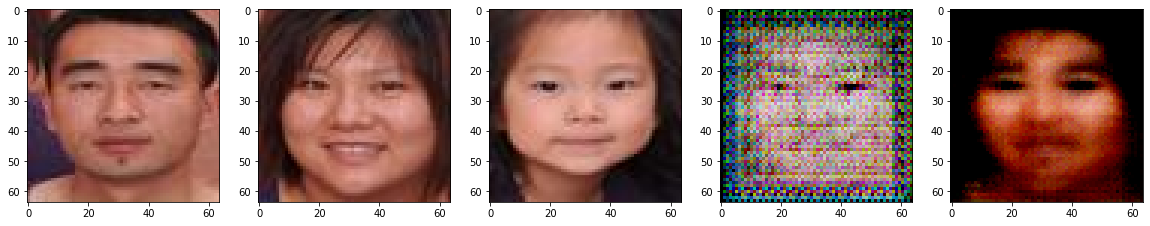

In [126]:
family_no = 1008
family_data = generate_image(all_families[family_no][0], all_families[family_no][1], all_families[family_no][2])
inp = [family_data[0],family_data[1]]
inp = tf.cast(inp, tf.float32)
father_inp = inp[0][tf.newaxis,...]
mother_inp = inp[1][tf.newaxis,...]
noise = tf.random.normal((1,4,4,64),mean= 0.0, stddev=1.0)

with tf.device('/gpu:0'):
    gen_output_sup = supervised([father_inp, mother_inp,noise], training=True)
    gen_output = unsupervised([father_inp, mother_inp,noise], training=True)
temp = gen_output.numpy()
temp1 = gen_output_sup.numpy()
fig = plt.figure(figsize=(20, 4))
fig.add_subplot(1,5,1)
plt.imshow(family_data[0])
fig.add_subplot(1,5,2)
plt.imshow(family_data[1])
fig.add_subplot(1,5,3)
plt.imshow(family_data[3])
fig.add_subplot(1,5,4)
plt.imshow(np.squeeze(temp))
fig.add_subplot(1,5,5)
plt.imshow(np.squeeze(temp1))

In [33]:
def pre_gen_upsample(filters, size,apply_batchnorm = False):
    initializer = tf.random_normal_initializer(mean, std_dev)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                   use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
        result.add(tf.keras.layers.ELU())

    return result

In [34]:
def Pre_Generator():
    
    up_stack_noise = [
    pre_gen_upsample(64,4,apply_batchnorm=True), #8x8x64
    pre_gen_upsample(32,4,apply_batchnorm=True), #16x16x64
    pre_gen_upsample(32,4,apply_batchnorm=True)  #32x32x32
    ]
    
    initializer = tf.random_normal_initializer(mean, sd_random_normal_init)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')
    
    noise = tf.keras.layers.Input(shape=(4,4,64))
    
    x = noise
    for up in up_stack_noise:
        x = up(x)
#     print(x.shape)
    output = last(x)
#     print(output.shape)
    return tf.keras.Model(inputs=noise, outputs=output)

In [55]:
pre_gen = Pre_Generator()
pre_gen.load_weights('checkpoint/pre_gan_weights/epoch_2_preG.pth')
pre_gen.summary()

gen = EncoderNN()
gen.summary()

w_l1 = pre_gen.layers[1].get_weights()
print(w_l1)
w_l1_len = len(w_l1)
for i in range(w_l1_len):
    w_l1[i] = w_l1[i].numpy()
    
print(w_l1)
gen.layers[4].set_weights(w_l1)

gen.layers[6].set_weights(pre_gen.layers[2].weights.numpy())


Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_90 (InputLayer)        [(None, 4, 4, 64)]        0         
_________________________________________________________________
sequential_174 (Sequential)  (None, 8, 8, 64)          65792     
_________________________________________________________________
sequential_175 (Sequential)  (None, 16, 16, 32)        32896     
_________________________________________________________________
sequential_176 (Sequential)  (None, 32, 32, 32)        16512     
_________________________________________________________________
conv2d_transpose_171 (Conv2D (None, 64, 64, 3)         1539      
Total params: 116,739
Trainable params: 116,483
Non-trainable params: 256
_________________________________________________________________
Model: "model_44"
__________________________________________________________________________________________________

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'